In [76]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel
from src import config
from src.plots import PlotGenerator

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [78]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [79]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the datas

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# No-Show Prediction: Model Training, Evaluation, and Comparative Analysis

This section covers:
- Model training (Logistic Regression, Random Forest, XGBoost)
- Hyperparameter tuning
- Evaluation with F1, Recall, Classification Report, R2, MSE, MAE
- ROC/AUC curves and confusion matrices
- Comparative analysis of all models

Assumes your DataFrame is named `df` and is already cleaned/preprocessed.

# 1. Data Preparation and Splitting

We will split the data into features and target, then into training and test sets. The target column is assumed to be `no_show` (1 = no-show, 0 = show).


In [80]:
# Keep only the specified columns for modeling
selected_features = [
    'WaitDays',
    'SMS_received',
    'Age',
    'Alcoholism',
    'Scholarship',
    'Gender',
    'Diabetes',
    'Handcap'
]
X = df[selected_features].copy()
y = df['No-show']

display(X.info())
display(X.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   WaitDays      110527 non-null  int64  
 1   SMS_received  110527 non-null  int64  
 2   Age           110527 non-null  float64
 3   Alcoholism    110527 non-null  int64  
 4   Scholarship   110527 non-null  int64  
 5   Gender        110527 non-null  int64  
 6   Diabetes      110527 non-null  int64  
 7   Handcap       110527 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 6.7 MB


None

,WaitDays,SMS_received,Age,Alcoholism,Scholarship,Gender,Diabetes,Handcap
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,9.183702,0.321026,37.088874,0.030400,0.098266,0.350023,0.071865,0.022248
std,15.254996,0.466873,23.110205,0.171686,0.297675,0.476979,0.258265,0.161543
min,-7.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,1.000000,55.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,178.000000,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000


# 2. Model Training 
We will train three models:
- Logistic Regression
- Random Forest
- XGBoost


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report, r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 2.1 Train base models (no tuning)
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)

base_models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

print('Base models trained.')

Train shape: (88421, 8), Test shape: (22106, 8)
Base models trained.
Base models trained.


,F1,Recall,Precision,Accuracy,ROC_AUC
Logistic Regression,0.029,0.015,0.354,0.796,0.663
Random Forest,0.249,0.194,0.349,0.764,0.665
XGBoost,0.058,0.031,0.401,0.795,0.729


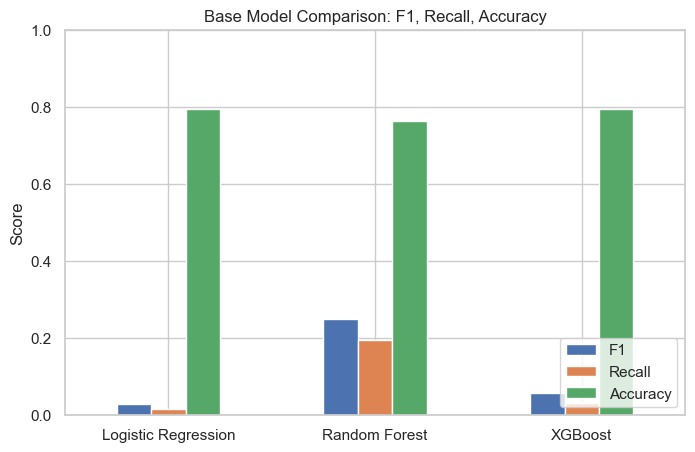

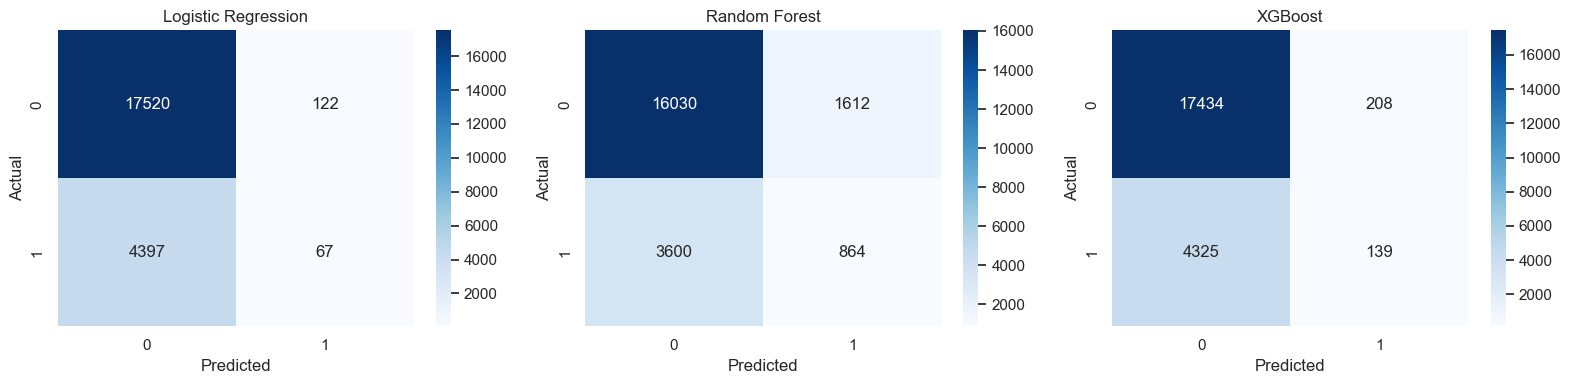

In [82]:
# Evaluate and plot metrics for base (untuned) models
base_results = {}
for name, model in base_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    base_results[name] = {
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'y_pred': y_pred
    }
# Print all base model metrics in a table
base_metrics_table = pd.DataFrame(base_results).T[
    ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
]
base_metrics_table.columns = ['F1', 'Recall', 'Precision', 'Accuracy', 'ROC_AUC']
display(base_metrics_table.style.format('{:.3f}'))

# Plot F1, Recall, Accuracy for base models
base_summary = pd.DataFrame(base_results).T[['f1', 'recall', 'accuracy']]
base_summary.columns = ['F1', 'Recall', 'Accuracy']
base_summary.plot(kind='bar', figsize=(8, 5))
plt.title('Base Model Comparison: F1, Recall, Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrices for all base models
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, axes = plt.subplots(1, len(base_results), figsize=(16, 4))
for ax, (name, res) in zip(axes, base_results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

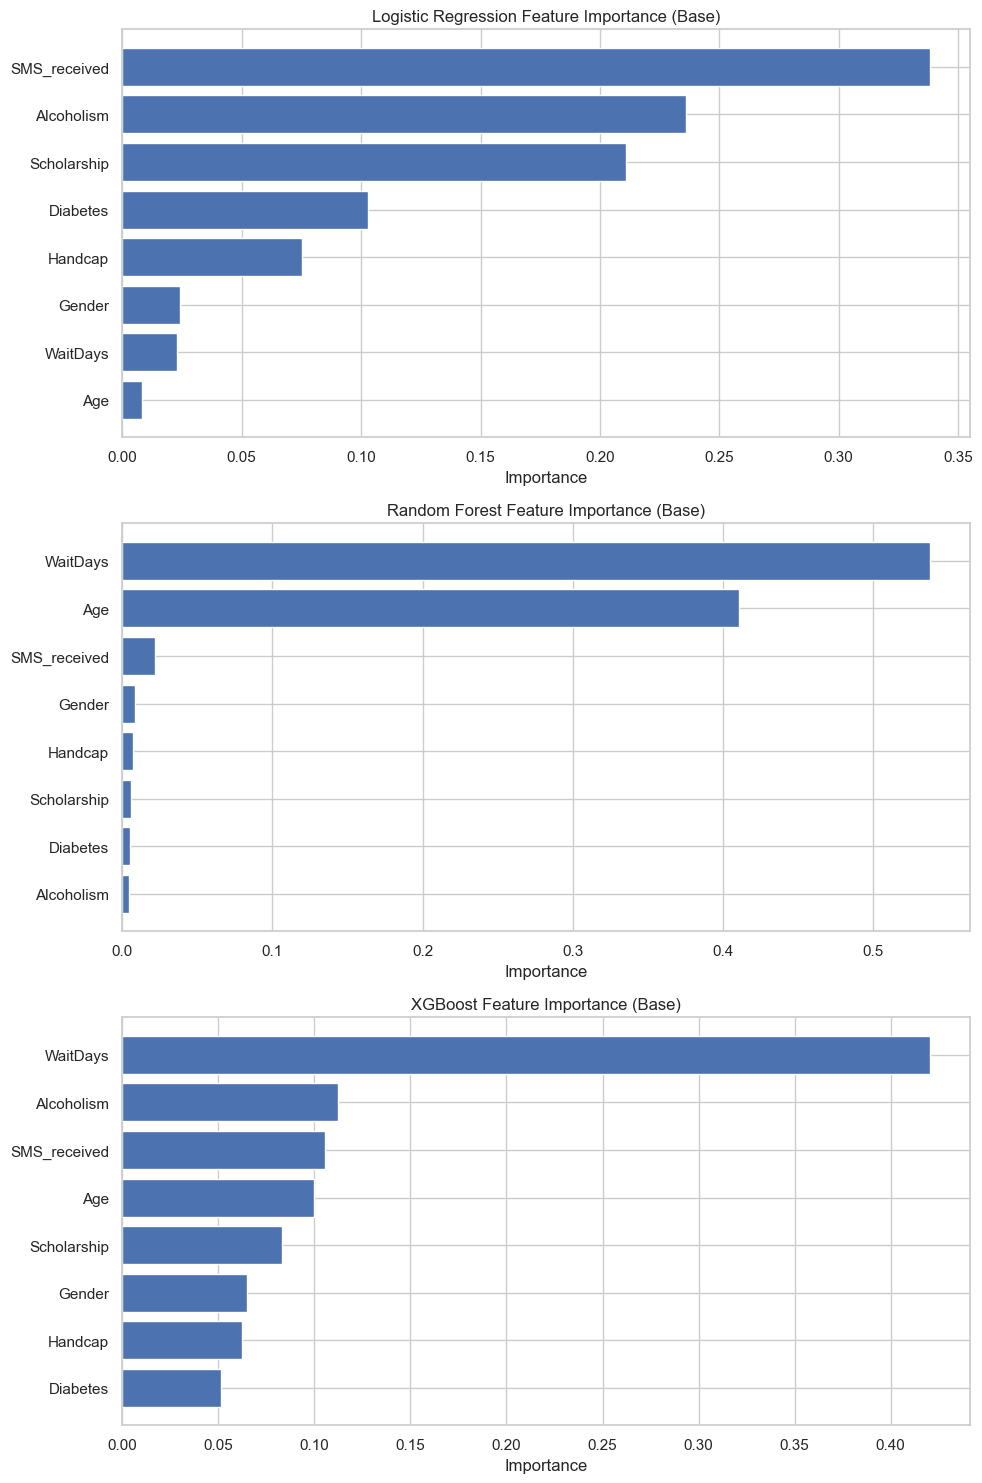

In [83]:
# Plot feature importances for all base models (Logistic Regression, Random Forest, XGBoost) horizontally
feature_names = X.columns

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

for ax, name in zip(axes, model_names):
    model = base_models[name]
    if name == 'Logistic Regression':
        importances = np.abs(model.coef_[0])
    elif name == 'Random Forest':
        importances = model.feature_importances_
    elif name == 'XGBoost':
        importances = model.feature_importances_
    else:
        continue
    indices = np.argsort(importances)[::-1]
    ax.barh(range(len(feature_names)), importances[indices], align='center')
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names[indices])
    ax.invert_yaxis()
    ax.set_title(f'{name} Feature Importance (Base)')
    ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()


# 4. Hyper Parameter Tuning

In [93]:
# Enhanced hyperparameter tuning with early stopping and time optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import multiprocessing as mp
import time

# Get number of CPU cores for parallelization
n_jobs = mp.cpu_count() - 1  # Leave one core free
print(f"Using {n_jobs} CPU cores for parallel processing")

# Create custom scoring function that balances accuracy and F1
def balanced_accuracy_f1_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # Weight accuracy more heavily than F1
    return 0.7 * acc + 0.3 * f1

balanced_scorer = make_scorer(balanced_accuracy_f1_score)

# Early stopping configuration
EARLY_STOP_PATIENCE = 5  # Stop if no improvement for 5 iterations
EARLY_STOP_THRESHOLD = 0.001  # Minimum improvement threshold
MAX_TUNING_TIME = 300  # Maximum time per model in seconds (5 minutes)

# Define optimized parameter grids with reduced search space for faster tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.5, 1, 2, 5],  # Reduced range
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000],  # Fixed to reduce combinations
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [100, 150, 200],  # Reduced range
        'max_depth': [10, 15, None],  # Reduced range
        'min_samples_split': [2, 5],  # Reduced range
        'min_samples_leaf': [1, 2],  # Reduced range
        'max_features': ['sqrt', 'log2'],  # Reduced options
        'class_weight': [None, 'balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 150, 200],  # Reduced range with early stopping
        'max_depth': [4, 6, 8],  # Reduced range
        'learning_rate': [0.1, 0.15],  # Reduced range
        'subsample': [0.9],  # Fixed to reduce combinations
        'colsample_bytree': [0.9],  # Fixed to reduce combinations
        'reg_alpha': [0, 0.1],  # Reduced range
        'reg_lambda': [1, 2],  # Reduced range
        'scale_pos_weight': [1, 2]  # Reduced range
    }
}

# Initialize models for tuning with early stopping capabilities
models_for_tuning = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, 
        n_jobs=n_jobs,
        oob_score=True
    ),
    'XGBoost': XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=RANDOM_STATE, 
        n_jobs=n_jobs,
        objective='binary:logistic',
        early_stopping_rounds=10,  # Early stopping for XGBoost
        verbosity=0  # Reduce output
    )
}

# Early stopping utility function
def early_stopping_check(scores_history, patience=EARLY_STOP_PATIENCE, threshold=EARLY_STOP_THRESHOLD):
    """Check if we should stop early based on score improvement"""
    if len(scores_history) < patience + 1:
        return False
    
    recent_scores = scores_history[-patience:]
    best_recent = max(recent_scores)
    previous_best = max(scores_history[:-patience]) if len(scores_history) > patience else 0
    
    improvement = best_recent - previous_best
    return improvement < threshold

# Perform enhanced hyperparameter tuning with early stopping
best_estimators = {}
tuning_results = {}
cv_results = {}

print("Starting optimized hyperparameter tuning with early stopping...")
print(f"Max tuning time per model: {MAX_TUNING_TIME} seconds")

for name, model in models_for_tuning.items():
    print(f"\nTuning {name}...")
    start_time = time.time()
    
    if name == 'Logistic Regression':
        # Fast approach for Logistic Regression with early stopping
        from sklearn.model_selection import cross_val_score
        
        best_score = 0
        best_params = None
        best_model = None
        scores_history = []
        
        # Define compatible solver-penalty combinations
        solver_penalty_combinations = [
            ('liblinear', 'l1'),
            ('liblinear', 'l2'),
            ('saga', 'l1'),
            ('saga', 'l2')
        ]
        
        C_values = [0.5, 1, 2, 5]
        class_weights = [None, 'balanced']
        
        print("Testing parameter combinations with early stopping...")
        combination_count = 0
        
        for solver, penalty in solver_penalty_combinations:
            for C in C_values:
                for class_weight in class_weights:
                    combination_count += 1
                    
                    # Check time limit
                    if time.time() - start_time > MAX_TUNING_TIME:
                        print(f"Time limit reached for {name}, stopping early...")
                        break
                    
                    try:
                        # Create parameter dictionary
                        params = {
                            'C': C,
                            'penalty': penalty,
                            'solver': solver,
                            'max_iter': 1000,
                            'class_weight': class_weight,
                            'random_state': RANDOM_STATE
                        }
                        
                        # Create and evaluate model using balanced scorer
                        temp_model = LogisticRegression(**params)
                        cv_scores = cross_val_score(temp_model, X_train, y_train, cv=3, scoring=balanced_scorer)
                        score = cv_scores.mean()
                        scores_history.append(score)
                        
                        if score > best_score:
                            best_score = score
                            best_params = params.copy()
                            # Train final model on full training set
                            temp_model.fit(X_train, y_train)
                            best_model = temp_model
                        
                        # Early stopping check
                        if combination_count >= 10 and early_stopping_check(scores_history):
                            print(f"Early stopping triggered for {name} after {combination_count} combinations")
                            break
                            
                    except Exception as e:
                        # Skip incompatible parameter combinations
                        continue
                
                if (time.time() - start_time > MAX_TUNING_TIME or 
                    (combination_count >= 10 and early_stopping_check(scores_history))):
                    break
            if (time.time() - start_time > MAX_TUNING_TIME or 
                (combination_count >= 10 and early_stopping_check(scores_history))):
                break
        
        best_estimators[name] = best_model
        tuning_results[name] = {
            'best_params': best_params,
            'best_score': best_score,
            'combinations_tested': combination_count
        }
        print(f"Best balanced score: {best_score:.4f}")
        print(f"Combinations tested: {combination_count}")
        print(f"Best params: {best_params}")
        
    else:
        # Use RandomizedSearchCV with reduced iterations for faster search
        if name == 'Random Forest':
            n_iter = 20  # Reduced iterations
        else:  # XGBoost
            n_iter = 15  # Reduced iterations for XGBoost
        
        # Add early stopping to XGBoost parameters
        if name == 'XGBoost':
            # Create validation set for early stopping
            X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
                X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
            )
            
            # Custom XGBoost with early stopping
            best_score = 0
            best_params = None
            best_model = None
            combinations_tested = 0
            
            import itertools
            param_combinations = list(itertools.product(*param_grids[name].values()))
            param_keys = list(param_grids[name].keys())
            
            # Shuffle combinations for randomized search
            import random
            random.shuffle(param_combinations)
            
            for combination in param_combinations[:n_iter]:
                combinations_tested += 1
                
                # Check time limit
                if time.time() - start_time > MAX_TUNING_TIME:
                    print(f"Time limit reached for {name}, stopping early...")
                    break
                
                params = dict(zip(param_keys, combination))
                params.update({
                    'use_label_encoder': False,
                    'eval_metric': 'logloss',
                    'random_state': RANDOM_STATE,
                    'n_jobs': n_jobs,
                    'objective': 'binary:logistic',
                    'early_stopping_rounds': 10,
                    'verbosity': 0
                })
                
                try:
                    temp_model = XGBClassifier(**params)
                    temp_model.fit(
                        X_train_split, y_train_split,
                        eval_set=[(X_val_split, y_val_split)],
                        verbose=False
                    )
                    
                    # Evaluate on validation set
                    y_pred = temp_model.predict(X_val_split)
                    score = balanced_accuracy_f1_score(y_val_split, y_pred)
                    
                    if score > best_score:
                        best_score = score
                        best_params = params.copy()
                        best_model = temp_model
                        
                except Exception as e:
                    continue
            
            best_estimators[name] = best_model
            tuning_results[name] = {
                'best_params': best_params,
                'best_score': best_score,
                'combinations_tested': combinations_tested
            }
            print(f"Best balanced score: {best_score:.4f}")
            print(f"Combinations tested: {combinations_tested}")
            print(f"Best params: {best_params}")
            
        else:  # Random Forest
            grid_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grids[name],
                n_iter=n_iter,
                cv=3,  # Reduced CV folds for speed
                scoring=balanced_scorer,
                n_jobs=n_jobs,
                verbose=0,  # Reduced verbosity
                random_state=RANDOM_STATE
            )
            
            grid_search.fit(X_train, y_train)
            
            best_estimators[name] = grid_search.best_estimator_
            tuning_results[name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'combinations_tested': n_iter
            }
            cv_results[name] = grid_search.cv_results_
            
            print(f"Best balanced score: {grid_search.best_score_:.4f}")
            print(f"Combinations tested: {n_iter}")
            print(f"Best params: {grid_search.best_params_}")
    
    elapsed_time = time.time() - start_time
    print(f"Tuning completed in {elapsed_time:.2f} seconds")

print("\nOptimized hyperparameter tuning completed!")

# Display tuning results summary
tuning_summary = pd.DataFrame({
    name: {
        'Best CV Score': results['best_score'],
        'Combinations Tested': results.get('combinations_tested', 'N/A'),
        'Best Parameters': str(results['best_params'])
    } for name, results in tuning_results.items()
}).T

display(tuning_summary)

Using 7 CPU cores for parallel processing
Starting optimized hyperparameter tuning with early stopping...
Max tuning time per model: 300 seconds

Tuning Logistic Regression...
Testing parameter combinations with early stopping...
Early stopping triggered for Logistic Regression after 10 combinations
Best balanced score: 0.5906
Combinations tested: 10
Best params: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}
Tuning completed in 4.08 seconds

Tuning Random Forest...
Early stopping triggered for Logistic Regression after 10 combinations
Best balanced score: 0.5906
Combinations tested: 10
Best params: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}
Tuning completed in 4.08 seconds

Tuning Random Forest...
Best balanced score: 0.6103
Combinations tested: 20
Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features'

,Best CV Score,Combinations Tested,Best Parameters
Logistic Regression,0.590603,10,"{'C': 0.5, 'penalty': 'l1', 'solver': 'libline..."
Random Forest,0.610302,20,"{'n_estimators': 100, 'min_samples_split': 5, ..."
XGBoost,0.640478,15,"{'n_estimators': 150, 'max_depth': 4, 'learnin..."


# 3. Model Evaluation

We will evaluate each model using:
- F1 Score
- Recall
- Precision
- Accuracy
- Classification Report
- ROC/AUC Curve
- Confusion Matrix

In [94]:
results = {}
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
# Model Performance Summary Table
summary = pd.DataFrame(results).T[
    ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
]
summary.columns = ['F1', 'Recall', 'Precision', 'Accuracy', 'ROC_AUC']
display(summary.style.format('{:.3f}'))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     17642
           1       0.32      0.57      0.41      4464

    accuracy                           0.67     22106
   macro avg       0.59      0.63      0.59     22106
weighted avg       0.76      0.67      0.70     22106


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     17642
           1       0.35      0.17      0.23      4464

    accuracy                           0.77     22106
   macro avg       0.58      0.55      0.55     22106
weighted avg       0.72      0.77      0.74     22106


XGBoost Classification Report:

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     17642
           1       0.35      0.17      0.23      4464

    accuracy                  

,F1,Recall,Precision,Accuracy,ROC_AUC
Logistic Regression,0.411,0.572,0.321,0.669,0.669
Random Forest,0.233,0.174,0.353,0.769,0.679
XGBoost,0.347,0.318,0.381,0.758,0.731


In [95]:
# --- Threshold Optimization for Accuracy ---
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np

threshold_results = {}
for name, res in results.items():
    y_proba = res['y_proba']
    if y_proba is not None:
        best_acc = 0
        best_thresh = 0.5
        best_f1 = 0
        best_recall = 0
        thresholds = np.linspace(0.1, 0.9, 41)
        for thresh in thresholds:
            y_pred_thresh = (y_proba >= thresh).astype(int)
            acc = accuracy_score(y_test, y_pred_thresh)
            f1 = f1_score(y_test, y_pred_thresh)
            recall = recall_score(y_test, y_pred_thresh)
            if acc > best_acc:
                best_acc = acc
                best_thresh = thresh
                best_f1 = f1
                best_recall = recall
        threshold_results[name] = {
            'best_threshold': best_thresh,
            'accuracy': best_acc,
            'f1': best_f1,
            'recall': best_recall
        }
        print(f"{name} - Best Threshold: {best_thresh:.2f} | Accuracy: {best_acc:.3f} | F1: {best_f1:.3f} | Recall: {best_recall:.3f}")
    else:
        print(f"{name} does not support probability prediction; skipping threshold optimization.")

# Display summary table
if threshold_results:
    thresh_df = pd.DataFrame(threshold_results).T
    display(thresh_df.style.format('{:.3f}'))

Logistic Regression - Best Threshold: 0.90 | Accuracy: 0.797 | F1: 0.006 | Recall: 0.003
Random Forest - Best Threshold: 0.88 | Accuracy: 0.798 | F1: 0.017 | Recall: 0.009
Random Forest - Best Threshold: 0.88 | Accuracy: 0.798 | F1: 0.017 | Recall: 0.009
XGBoost - Best Threshold: 0.66 | Accuracy: 0.798 | F1: 0.025 | Recall: 0.013
XGBoost - Best Threshold: 0.66 | Accuracy: 0.798 | F1: 0.025 | Recall: 0.013


,best_threshold,accuracy,f1,recall
Logistic Regression,0.900,0.797,0.006,0.003
Random Forest,0.880,0.798,0.017,0.009
XGBoost,0.660,0.798,0.025,0.013


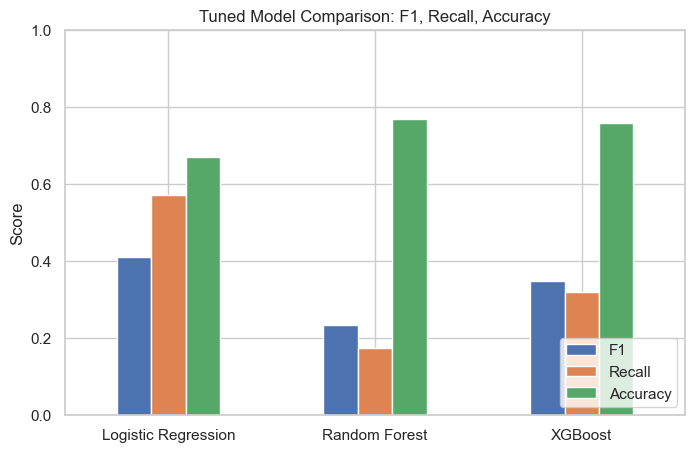

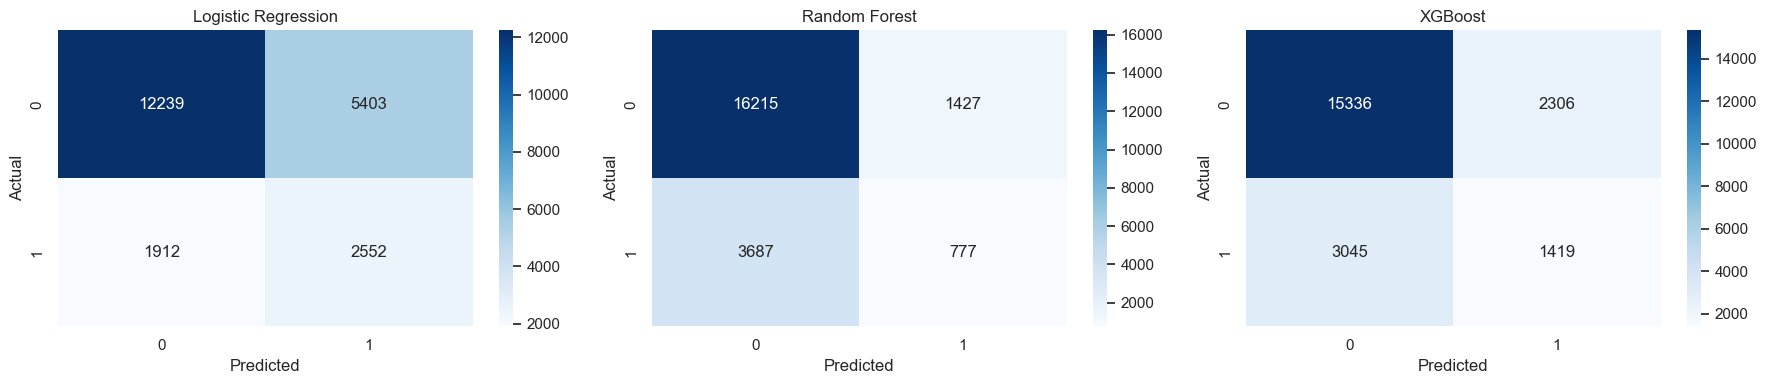

In [96]:
# Plot F1, Recall, Accuracy for tuned models
results_summary = pd.DataFrame(results).T[['f1', 'recall', 'accuracy']]
results_summary.columns = ['F1', 'Recall', 'Accuracy']

results_summary.plot(kind='bar', figsize=(8, 5))
plt.title('Tuned Model Comparison: F1, Recall, Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrices for all models
num_models = len(results)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 4))
if num_models == 1:
    axes = [axes]
for ax, (name, res) in zip(axes, results.items()):
    cm = res.get('confusion_matrix', confusion_matrix(y_test, res['y_pred']))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()


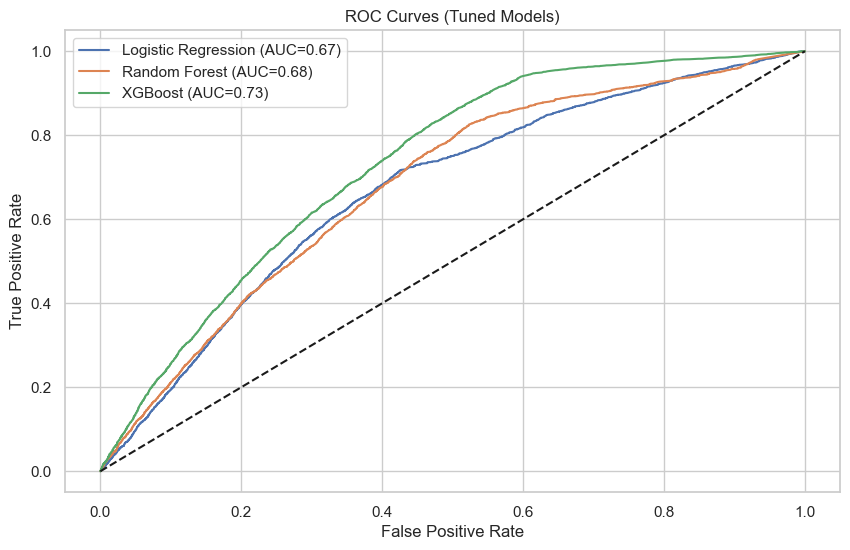

In [97]:
# Plot ROC Curves for all models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))
for name, res in results.items():
    y_proba = res['y_proba']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC={res["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Tuned Models)')
plt.legend()
plt.show()

# 4. Comparative Analysis and Summary

We will now compare the performance of all models using the collected metrics and summarize the findings.

# 5. Interpretation and Next Steps

- Review the summary table and plots to select the best model for your use case.
- Investigate misclassifications using confusion matrices.
- Consider feature importance (e.g., from Random Forest or XGBoost) for further insights.
- For deployment, retrain the best model on the full dataset and export it.
- For further improvement, try advanced feature engineering, ensemble methods, or deep learning models.

In [98]:
# Test predictions on a sample from X_test using all tuned models
n_samples = 5
sample_idx = np.random.choice(X_test.index, size=n_samples, replace=False)
sample_X = X_test.loc[sample_idx]
if 'No-show' in df.columns:
    sample_y = df.loc[sample_idx, 'No-show']
else:
    sample_y = y_test.loc[sample_idx]

print('Sample predictions:')
for name, model in best_estimators.items():
    preds = model.predict(sample_X)
    print(f'\n{name} predictions:')
    for i, idx in enumerate(sample_idx):
        actual = sample_y.iloc[i]
        pred = preds[i]
        status = "✅ PASS" if pred == actual else "❌ FAIL"
        print(f'  Index {idx}: Predicted={pred}, Actual={actual} --> {status}')

Sample predictions:

Logistic Regression predictions:
  Index 63121: Predicted=1, Actual=0 --> ❌ FAIL
  Index 108645: Predicted=0, Actual=1 --> ❌ FAIL
  Index 40739: Predicted=0, Actual=0 --> ✅ PASS
  Index 56222: Predicted=0, Actual=0 --> ✅ PASS
  Index 39737: Predicted=0, Actual=0 --> ✅ PASS

Random Forest predictions:
  Index 63121: Predicted=1, Actual=0 --> ❌ FAIL
  Index 108645: Predicted=0, Actual=1 --> ❌ FAIL
  Index 40739: Predicted=0, Actual=0 --> ✅ PASS
  Index 56222: Predicted=0, Actual=0 --> ✅ PASS
  Index 39737: Predicted=0, Actual=0 --> ✅ PASS

XGBoost predictions:
  Index 63121: Predicted=1, Actual=0 --> ❌ FAIL
  Index 108645: Predicted=0, Actual=1 --> ❌ FAIL
  Index 40739: Predicted=0, Actual=0 --> ✅ PASS
  Index 56222: Predicted=0, Actual=0 --> ✅ PASS
  Index 39737: Predicted=0, Actual=0 --> ✅ PASS


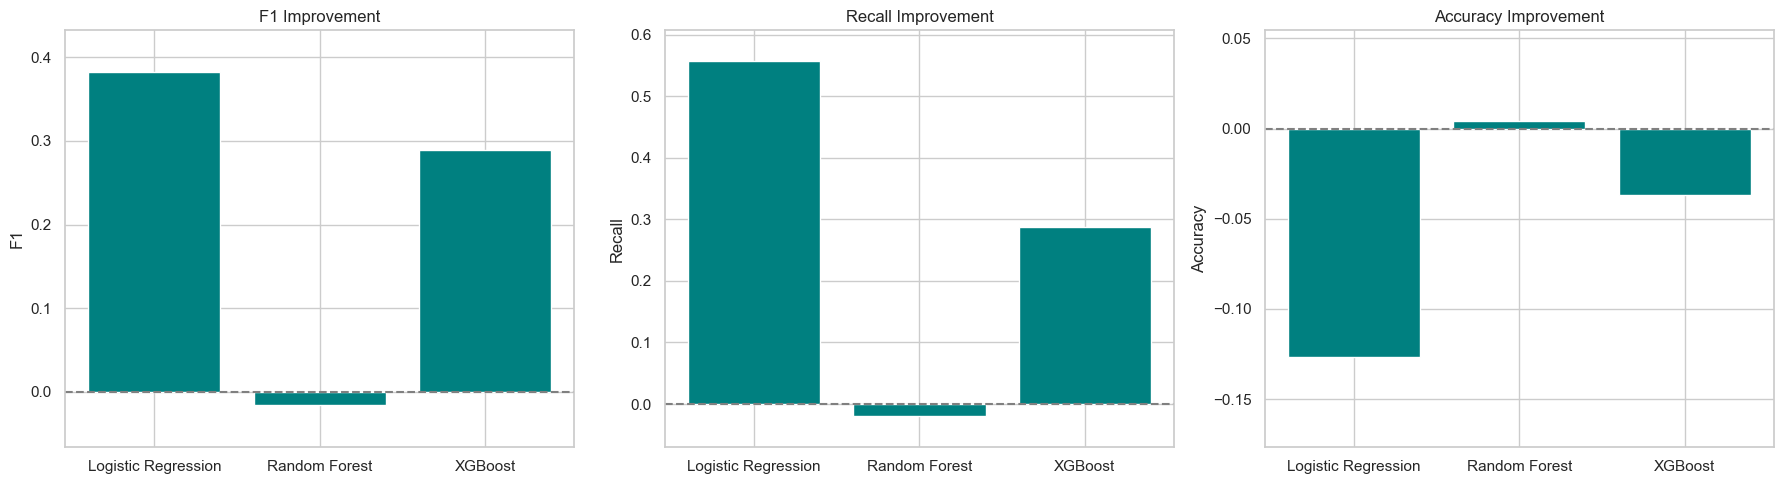

In [99]:
# Prepare DataFrame for improvement plotting
metrics = ['f1', 'recall', 'accuracy']
plot_df = pd.DataFrame({
    f"{m}_base": [base_results[name][m] for name in model_names] for m in metrics
})
for m in metrics:
    plot_df[f"{m}_tuned"] = [results[name][m] for name in model_names]
plot_df.index = model_names

#
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, m in enumerate(metrics):
    axes[i].bar(plot_df.index, plot_df[f"{m}_tuned"] - plot_df[f"{m}_base"], color='teal')
    axes[i].set_title(f"{m.capitalize()} Improvement")
    axes[i].set_ylabel(f"{m.capitalize()}")
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].set_ylim(min(0, (plot_df[f"{m}_tuned"] - plot_df[f"{m}_base"]).min() - 0.05), 
                     (plot_df[f"{m}_tuned"] - plot_df[f"{m}_base"]).max() + 0.05)
plt.tight_layout()
plt.show()